In [28]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Sequential, layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from utils.path import list_images
import matplotlib.pyplot as plt
from utils.loader import DataLoader
import numpy as np
import argparse
import os
import pathlib
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print("Num GPUs Available: " , len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [2]:
print(tf.__version__)

2.7.0


In [4]:
batch_size = 16
img_height = 128
img_width = 128

PATH = os.path.join(r'Dataset')
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'val')
test_dir = os.path.join(PATH, 'test')

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  shuffle=True,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  validation_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 27359 files belonging to 2 classes.
Found 5420 files belonging to 2 classes.
Found 5433 files belonging to 2 classes.


In [ ]:
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [14]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [ ]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [23]:
img_shape = (img_height, img_width) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=img_shape,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

In [22]:
image_batch, label_batch = next(iter(train_ds))
# x = base_model(image_batch)
# x = tf.keras.layers.GlobalAveragePooling2D()(x)
# bin_out = tf.keras.layers.Dense(1)(x)
# print(bin_out.shape)

(16, 1)


In [27]:
inputs = tf.keras.Input(shape=(128, 128, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1)(x)
model = Model(inputs, outputs)

In [32]:
lr = 1e-4
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
# model.summary()

In [33]:
loss_init, accuracy_init = model.evaluate(val_ds)

339/339 [==============================] - 8s 21ms/step - loss: 0.7269 - accuracy: 0.7446


In [34]:
history = model.fit(train_ds,
                    epochs=10,
                    validation_data=val_ds)

Epoch 1/10
1710/1710 [==============================] - 52s 29ms/step - loss: 0.1130 - accuracy: 0.9552 - val_loss: 0.0208 - val_accuracy: 0.9939
Epoch 2/10
1710/1710 [==============================] - 50s 29ms/step - loss: 0.0209 - accuracy: 0.9941 - val_loss: 0.0087 - val_accuracy: 0.9983
Epoch 3/10
1710/1710 [==============================] - 51s 29ms/step - loss: 0.0115 - accuracy: 0.9969 - val_loss: 0.0049 - val_accuracy: 0.9994
Epoch 4/10
1710/1710 [==============================] - 51s 29ms/step - loss: 0.0079 - accuracy: 0.9979 - val_loss: 0.0032 - val_accuracy: 0.9998
Epoch 5/10
1710/1710 [==============================] - 51s 30ms/step - loss: 0.0057 - accuracy: 0.9983 - val_loss: 0.0028 - val_accuracy: 0.9996
Epoch 6/10
1710/1710 [==============================] - 50s 29ms/step - loss: 0.0053 - accuracy: 0.9985 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 7/10
1710/1710 [==============================] - 51s 29ms/step - loss: 0.0040 - accuracy: 0.9988 - val_loss: 0.0017 -

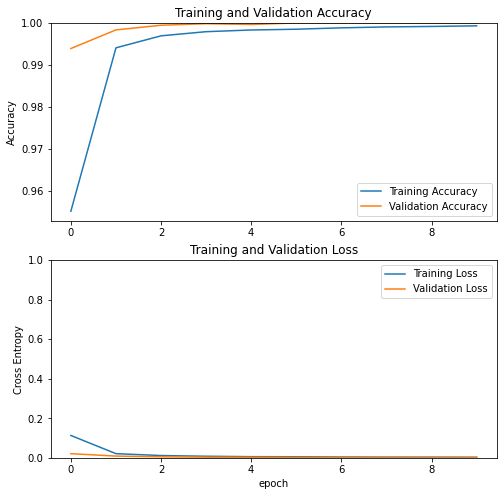

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [36]:
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [37]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr/10),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
print(len(model.trainable_variables))

56


In [38]:
history_fine = model.fit(train_ds,
                         epochs=10,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 10/10
1710/1710 [==============================] - 101s 55ms/step - loss: 8.9634e-04 - accuracy: 0.9997 - val_loss: 1.3014e-06 - val_accuracy: 1.0000


In [39]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

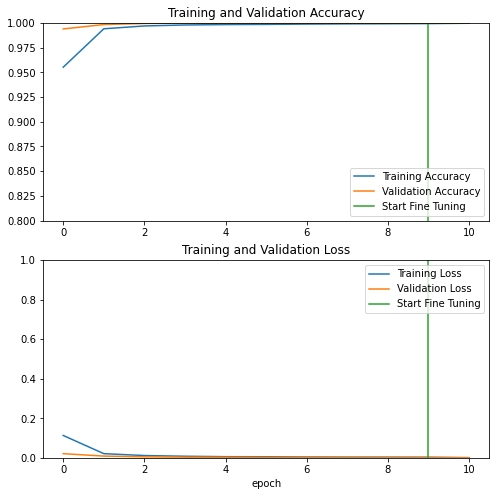

In [41]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([10-1,10-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([10-1,10-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [43]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

340/340 [==============================] - 8s 23ms/step - loss: 4.8288e-05 - accuracy: 1.0000
Test accuracy : 1.0


Predictions:
 [0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0]
Labels:
 [0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0]


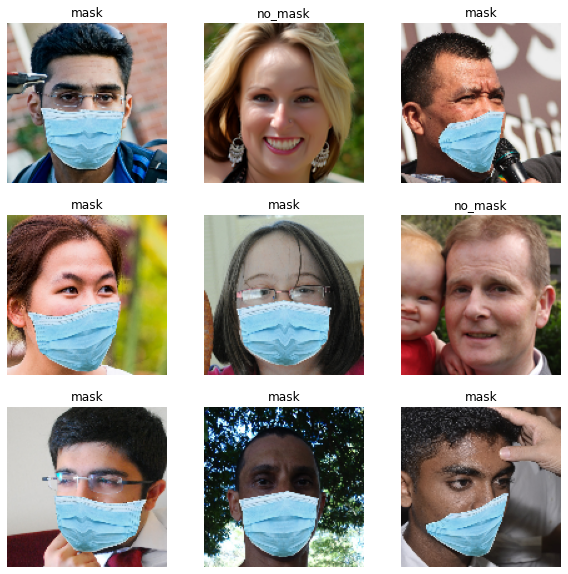

In [45]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [48]:
print('Saving model...')
model.save('model/MaskNet', save_format='h5')

Saving model...


C:\Users\chung\anaconda3\envs\tf2.7v2\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
